<a href="https://colab.research.google.com/github/hammertoe/machine_learning/blob/master/trading_algo_tutorial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
# To run this notebook you need to get a Quandl key free from their website
# and put it below

import os
os.environ['QUANDL_API_KEY'] = 'XXX'

In [150]:
import datetime as dt
import matplotlib.pyplot as plt
from matplotlib import style
import pandas as pd
import numpy as np
import pandas_datareader.data as web

style.use('ggplot')

start = dt.datetime(2018, 8, 1)
end = dt.datetime.now()

df = web.DataReader("PERTH/USD_JPY_D", 'quandl', start, end)

print(df)


            BidHigh  AskHigh  BidLow  AskLow  BidAverage  AskAverage
Date                                                                
2019-12-31   108.85   108.91  108.61  108.67      108.69      108.75
2019-12-30   109.43   109.48  109.11  109.15      109.23      109.28
2019-12-27   109.55   109.64  109.45  109.49      109.49      109.56
2019-12-26   109.56   109.67  109.29  109.42      109.47      109.58
2019-12-25   109.32   109.50  109.24  109.36      109.30      109.43
...             ...      ...     ...     ...         ...         ...
2018-08-07   111.32   111.39  111.23  111.28      111.29      111.35
2018-08-06   111.33   111.41  111.14  111.22      111.25      111.31
2018-08-03   111.77   111.80  111.59  111.68      111.67      111.72
2018-08-02   111.67   111.71  111.52  111.56      111.59      111.64
2018-08-01   112.08   112.15  111.71  111.81      111.90      111.95

[369 rows x 6 columns]


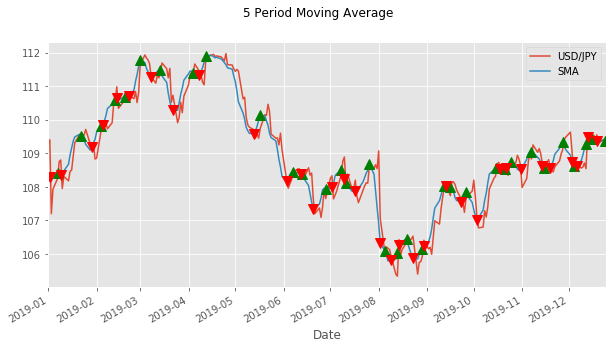

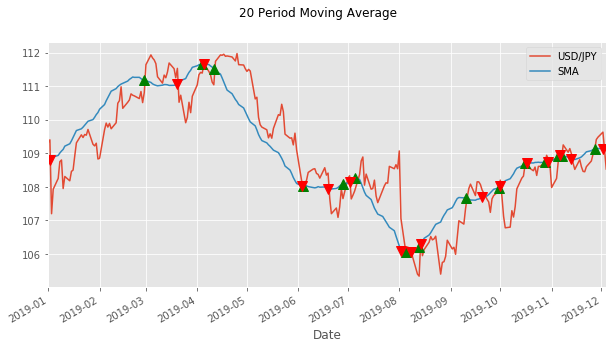

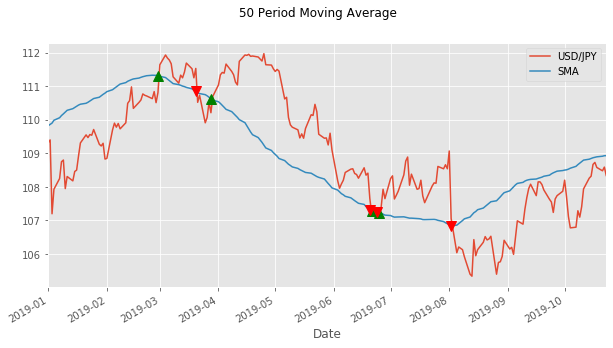

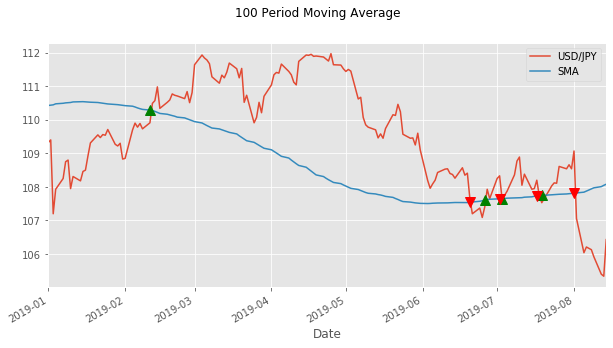

In [151]:
def calc_signals(df, sma_len):
  sma_len = int(sma_len)
  df2 = df.copy()
  df2['sma'] = df2['BidAverage'].rolling(sma_len).mean()
  df2.dropna(inplace=True)

  df2 = df2.loc['2019']


  df2['diff'] = np.where(df2['sma'] - df2['BidAverage'] > 0, 1, 0)
  df2['signal'] = df2['diff'].diff()

  return df2

def plot_results(df, sma_len):
  sma_len = int(sma_len)
  df2 = calc_signals(df, sma_len)
  ax1 = df2[['BidAverage','sma']].plot(figsize=(10,5))

  ax1.plot(df2[df2['signal'] == 1.0].index, 
           df2[df2['signal'] == 1.0].sma,
             '^', markersize=10, color='g')

  ax1.plot(df2[df2['signal'] == -1.0].index, 
           df2[df2['signal'] == -1.0].sma,
             'v', markersize=10, color='r')
  fig = ax1.get_figure()
  ax1.legend(('USD/JPY', 'SMA'))
  fig.suptitle(f"{sma_len} Period Moving Average")
  fig.show()

plot_results(df, 5)
plot_results(df, 20)
plot_results(df, 50)
plot_results(df, 100)

In [0]:
def simulate(df, sma_len):
  df2 = calc_signals(df, sma_len)

  jpy = 1000
  usd = 0.0
  for i,row in df2.iterrows():
    if jpy > 0 and row['signal'] == 1:
      usd = jpy / row['AskAverage']
      jpy = 0.0
    if usd > 0 and row['signal'] == -1:
      jpy = usd * row['BidAverage']
      usd = 0.0

  final = jpy + usd * df2['BidAverage'][-1]
  return final

In [153]:
!pip install hyperopt

In [154]:
from hyperopt import hp, tpe, fmin, Trials

# a wrapper just for convenience that takes a
# dictionary of parameters as passed by hyperopt
# and passes in the parameter we want to the simulation
# it also negates the return value as hyperopt is designed
# to find the MINIMUM value
def wrapper(params):
  sma_len = params['sma_len']
  return -simulate(df, sma_len)

# The search space, in this case just a single parameter
# that goes from 1 to 200 in steps of 1
space = {
  'sma_len': hp.quniform('sma_len', 1, 200, 1),
}

# The trials object is a database to hold the results in
trials = Trials()

# The actual call to hyperopt to do the optimisation
best = fmin(wrapper,
  space=space,
  algo=tpe.suggest,
  max_evals=50,
  trials=trials)

print(best)



100%|██████████| 50/50 [00:01<00:00, 34.09it/s, best loss: -1038.7439315204344]
{'sma_len': 14.0}


1038.7439315204344


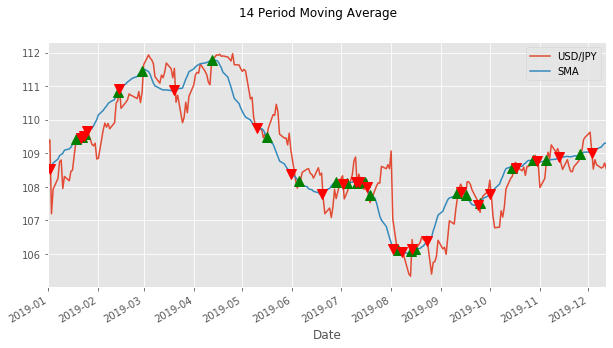

In [155]:
best_sma_len = best['sma_len']

print(simulate(df, best_sma_len))

plot_results(df, best_sma_len)